In [11]:
# 파이썬≥3.5 필수
import sys
assert sys.version_info >= (3, 5)
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
# 깔끔한 그래프 출력을 위해 %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
from matplotlib import font_manager, rc
import platform
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False
# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3
# 그래픽 출력을 조금 더 고급화하기 위한 라이브러리
import seaborn as sns

#과학 기술 통계 라이브러리
import scipy as sp
from scipy import stats
# 사이킷런 ≥0.20 필수 : 0.20에서 데이터 변환을 위한 Transformer클래스가 추가됨
import sklearn
assert sklearn.__version__ >= "0.20"

# 데이터를 분할할 때 동일한 분할을 만들기 위해서
# 모델을 만드는 작업을 여러 번에 걸쳐서 하는 경우 시드가 변경이 되서 훈련용 데이터가
# 자주 변경이 되면 결국 모든 데이터를 가지고 모델을 생성하는 결과
# Overfit이 될 가능성이 높아짐
np.random.seed(42)


## MINIST Data

In [2]:
# 데이터 다운로드
# 디셔너리 형태로 다운로드
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print(mnist.keys())

C:\Users\USER\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [3]:
# 피쳐와 타겟 가져오기
X, y = mnist['data'], mnist['target']
print(X.shape)
# 데이터는 784 픽셀을 가진 흑백 이미지로 실제 크기는 28 * 28
# 각 픽셀은 0~255 까지의 값
print(y.shape)

(70000, 784)
(70000,)


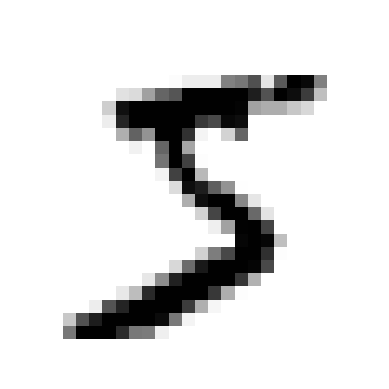

In [4]:
# 하나의 이미지 출력
some_digit=X[0] # 이 이미지는 784 픽셀로 구성
some_digit_image = some_digit.reshape(28,28) # 2차원 이미지로 변환
plt.imshow(some_digit_image, cmap = mpl.cm.binary)
plt.axis('off')
plt.show()

In [5]:
# 출력한 이미지의 레이블을 확인
print(y[0])

5


In [6]:
# 여러 개의 이미지를 출력하기 위한 함수
# 첫 번째 매개변수는 이미지
# 두 번째 매개변수는 하나의 행에 출력할 이미지의 수 : 기본값은 10
# 세 번째 매개변수는 옵션으로 디셔너리를 설정
# 여러 개의 옵션을 설정해야 하는 경우 각 매개변수를 나열하는 것은 함수의 가독성을 떨어뜨림
# 이런 경우에는 매개변수를 하나로 묶어야 하는데 dict나 class
# 생략이 가능한 옵션을 많이 가지고 있으면 dict가 낫고 그렇지 않으면 class를 사용


def plot_digits(instances, images_per_row=10, **options):
    size = 28
    # 행에 출력할 이미지의 개수를 설정
    images_per_row = min(len(instances), images_per_row)
    # 이미지 크기 설정
    images = [instance.reshape(size,size) for instance in instances]
    # 행의 개수를 출력
    n_rows = (len(instances)-1) // images_per_row+1
    # 이미지들을 저장할 리스트
    row_images = []
    n_empty = n_rows*images_per_row - len(instances)
    
    # 0으로 가득찬 행렬을 만들어서 row_images에 저장
    images.append(np.zeros((size, size * n_empty)))
    
    # 행 단위로 순회하면서 실제 이미지를 추가
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    #이미지 출력
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off") 
    

그림 저장: more_digits_plot


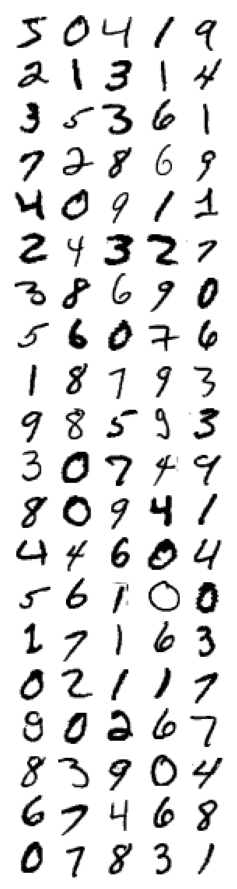

In [7]:
# 여러 개의 이미지 출력 함수 확인
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=5)
save_fig("more_digits_plot")
plt.show()

In [8]:
# 타겟의 자료형 확인
print(type(y[0]))
# 범주형 데이터의 자료형은 정수를 권장
# 타겟의 자료형 변경
# 간혹 np.int로 변경하는 경우가 있는데 numpy 버전이 변경되면서 없어짐
y = y.astype(np.uint8)
print(type(y[0]))

<class 'str'>
<class 'numpy.uint8'>


## 이진 분류를 위한 데이터 생성

In [9]:
# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 이진 분류는 True 와 False로 분류
# 이진 분류의 경우는 Target이 bool
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
print(y_train_5[0])

True


## SGDClassifier를 이용한 이진분류

### 훈련 및 데이터 예측

In [10]:
from sklearn.linear_model import SGDClassifier

#훈련에 사용할 모델을 생성 - 하이퍼 파라미터를 설정
#max_iter는 최대 반복 횟수
#tol은 정밀도
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

#훈련
sgd_clf.fit(X_train, y_train_5)

#예측 - feature는 2차원 배열 이상이어야 함
sgd_clf.predict([some_digit])

array([ True])

### k겹 교차 검증을 이용한 정확도 측정

In [11]:
from sklearn.model_selection import cross_val_score
# 3번 교차 검증을 수행하는데 평가 지표는 정확도
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95, 0.96, 0.96])

In [12]:
# 새로운 분류기를 가지고 훈련하고 교차 검증
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.911, 0.909, 0.909])

## 오차 행렬(confusion matrix)

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
# 확률적 경사 하강법 모델을 가지고 훈련한 후 값을 예측
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# 오차 행렬 출력
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [14]:
#다른 평가 지표 계산
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("정확도:", accuracy_score(y_train_5, y_train_pred))
print("정밀도:", precision_score(y_train_5, y_train_pred))
print("재현율:", recall_score(y_train_5, y_train_pred))
print("f1_score:", f1_score(y_train_5, y_train_pred))

정확도: 0.9570333333333333
정밀도: 0.8370879772350012
재현율: 0.6511713705958311
f1_score: 0.7325171197343846


In [15]:
# 결정 임계값 - 기본 값은 0
# 자신의 점수를 출력
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores) # 임계값인 0 보다 크기 때문에 True

# 전체 훈련 데이터의 점수를 출력
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
print(y_scores)

[2164.22]
[  1200.931 -26883.792 -33072.035 ...  13272.127  -7258.472 -16877.508]


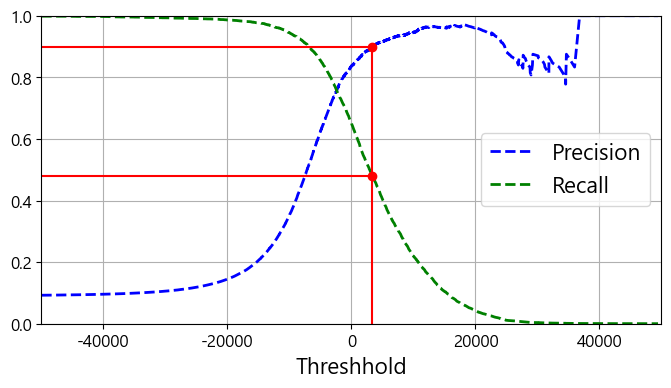

In [16]:
# 정밀도와 재현율 트레이드 오프
from sklearn.metrics import precision_recall_curve
# 정밀도, 재현율, 임계값을 전부 추출
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# 정밀도와 재현율 그래프를 그려주는 함수
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall", linewidth=2)
    
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshhold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

#정밀도가 0.9가 되는 위치의 재현율 조회
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.plot([threshold_90_precision, threshold_90_precision], [0,0.9], "r")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r")
plt.plot([-50000, threshold_90_precision,],[recall_90_precision, recall_90_precision], "r")

plt.plot([threshold_90_precision],[0.9],"ro")
plt.plot([threshold_90_precision],[recall_90_precision],"ro")
plt.show()

In [17]:
# 정밀도가 0.9가 되는 지점을 이용해서 예측
y_train_pred_90 = (y_scores >= threshold_90_precision)
# 정밀도
print(precision_score(y_train_5, y_train_pred_90))
# 재현율
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### ROC 곡선

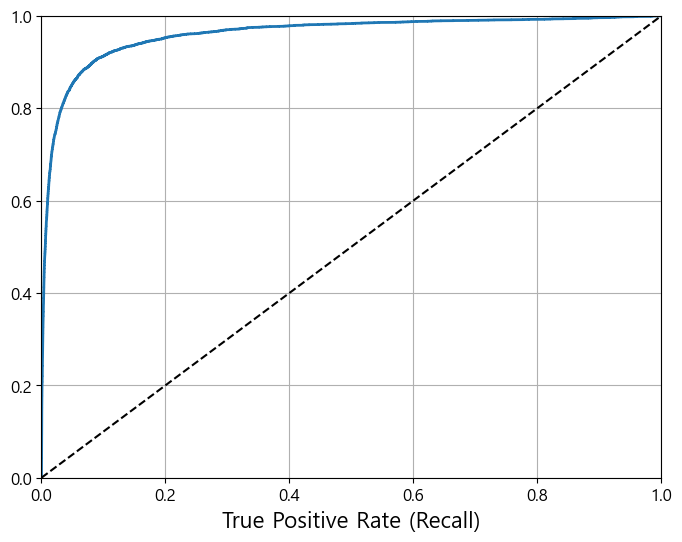

In [18]:
from sklearn.metrics import roc_curve

#그래프 사용할 값 계산
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--') #대각선 - 완전 랜덤인 경우
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)
    plt.xlabel("True Positive Rate (Recall)", fontsize=16)
    plt.grid(True)
    
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
plt.show()

In [19]:
# ROC 곡선의 면적
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_5, y_scores))

0.9604938554008616


## 다중 분류

### 이진 분류기를 이용한 다중 분류

In [20]:
from sklearn.svm import SVC
# 이진 분류기
svm_clf = SVC(gamma="auto", random_state=42)
# 이진 분류기를 이용해서 0 - 9 까지 10개를 분류
svm_clf.fit(X_train[:1000], y_train[:1000])
print(svm_clf.predict([some_digit]))
# 결정 점수를 확인
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)

[5]
[[ 2.816  7.092  3.83   0.794  5.889  9.297  1.799  8.104 -0.228  4.838]]


### SGD를 이용한 다중 분류

In [21]:
sgd_clf.fit(X_train, y_train)
# 예측
print(sgd_clf.predict([some_digit]))
# 결정 점수 확인
print(sgd_clf.decision_function([some_digit]))

[3]
[[-31893.031 -34419.691  -9530.64    1823.732 -22320.148  -1385.805
  -26188.911 -16147.513  -4604.355 -12050.767]]


In [22]:
# 교차 검증을 이용한 정확도 확인
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.874, 0.858, 0.869])

In [23]:
# 특성이 여러 개이고 이 특성의 값의 분포가 일정하지 않은 경우
# scailing 이나 standardization을 고려
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.898, 0.891, 0.902])

In [24]:
y_train_predict = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5860   63    0    0    0    0    0    0    0    0]
 [6675   67    0    0    0    0    0    0    0    0]
 [5932   26    0    0    0    0    0    0    0    0]
 [5913  218    0    0    0    0    0    0    0    0]
 [5821   21    0    0    0    0    0    0    0    0]
 [1891 3530    0    0    0    0    0    0    0    0]
 [5796  122    0    0    0    0    0    0    0    0]
 [6251   14    0    0    0    0    0    0    0    0]
 [5741  110    0    0    0    0    0    0    0    0]
 [5903   46    0    0    0    0    0    0    0    0]]


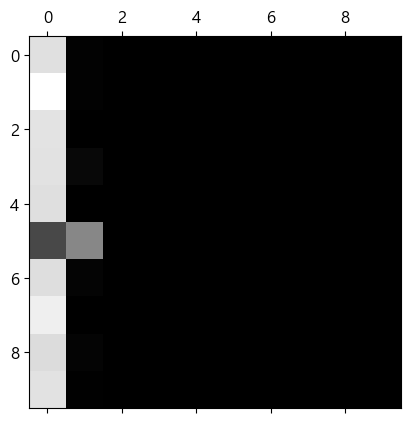

In [25]:
# 오차 행렬을 시각화
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

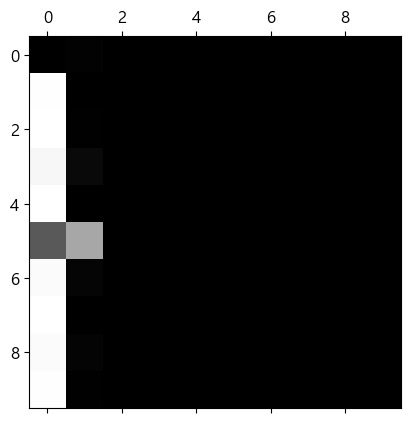

In [26]:
# 오차 행렬을 각 행의 합계로 나누고 대각선을 0으로 채워서 오류를 조금 더 눈에 띄게 출력
# 분류 모델에서는 이 행렬을 반드시 출력해보는 것이 좋음
# 잘못 분류된 모델을 확인해 볼 수 있음
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
# 주 대각선 방향을 0으로 채움
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### 다중 레이블 분류

In [27]:
# 출력해야 할 레이블이 여러 개인 경우
# 이미지를 가지고 7보다 큰지 그리고 홀수인지 여부를 같이 리턴해야 하는 경우
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
# 2개를 가지고 MultiLabel 생성
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

## 분류 알고리즘

### LDA(선형 판별 분석)

In [28]:
# borrowscore와 payment_inc_ratio에 따른 outcome 선형 판별 분석
loan3000 = pd.read_csv("./data/data/data/loan3000.csv")
print(loan3000.head())
loan3000.info()

   Unnamed: 0   outcome            purpose_    dti  borrower_score  \
0       32109  paid off  debt_consolidation  21.23            0.40   
1       16982   default         credit_card  15.49            0.40   
2       25335  paid off  debt_consolidation  27.30            0.70   
3       34580  paid off      major_purchase  21.11            0.40   
4       14424   default  debt_consolidation  16.46            0.45   

   payment_inc_ratio  
0            5.11135  
1            5.43165  
2            9.23003  
3            2.33482  
4           12.10320  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3000 non-null   int64  
 1   outcome            3000 non-null   object 
 2   purpose_           3000 non-null   object 
 3   dti                3000 non-null   float64
 4   borrower_score     3000 non-null   float64

In [29]:
# 타겟을 범주형으로 변환
loan3000.outcome = loan3000.outcome.astype("category")

print(loan3000.corr())
# 독립 변수와 종속 변수를 설정
predictors = ['borrower_score', 'payment_inc_ratio']
outcome='outcome'

# 독립 변수 - feature
X = loan3000[predictors]
# 종속 변수 - target
y = loan3000[outcome]

print(X)
print(y)



                   Unnamed: 0       dti  borrower_score  payment_inc_ratio
Unnamed: 0           1.000000 -0.095606        0.249030          -0.102143
dti                 -0.095606  1.000000       -0.258860           0.232972
borrower_score       0.249030 -0.258860        1.000000          -0.109575
payment_inc_ratio   -0.102143  0.232972       -0.109575           1.000000
      borrower_score  payment_inc_ratio
0               0.40            5.11135
1               0.40            5.43165
2               0.70            9.23003
3               0.40            2.33482
4               0.45           12.10320
...              ...                ...
2995            0.50           18.36620
2996            0.60            1.80421
2997            0.20           15.42180
2998            0.45            8.92335
2999            0.40           12.88190

[3000 rows x 2 columns]
0       paid off
1        default
2       paid off
3       paid off
4        default
          ...   
2995    paid off
2

C:\Users\USER\AppData\Local\Temp\ipykernel_17008\2282781565.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(loan3000.corr())


In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
# 최적의 값을 확인
print(pd.DataFrame(loan_lda.scalings_, index=X.columns))

                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


In [31]:
# 처음 5개의 데이터 판별
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]), columns=loan_lda.classes_)
print(pred.head())

# 결과 해석(default와 paid_off의 확률을 확인)
# 첫번째 데이터가 default일 확률이 55.3544%, paid off일 확률이 44.6456%

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


#### loan_200.csv 파일의 데이터를 읽어서 payment_inc_ratio와 dti를 이용해서 outcome을 예측

In [32]:
from sklearn.neighbors import KNeighborsClassifier

# 데이터 불러오기
loan200 = pd.read_csv('./data/data/data/loan200.csv')

predictors = ["payment_inc_ratio", "dti"]
outcome = 'outcome'

# 테스트 데이터와 예측 변수 및 타겟 벡터 분리
# newloan이라는 이름으로 데이터 하나 빼두기
newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]
print(X)
print(y)


     payment_inc_ratio    dti
1              5.46933  21.33
2              6.90294   8.97
3             11.14800   1.83
4              3.72120  10.81
5              1.89923  11.34
..                 ...    ...
196           11.66300  26.09
197            2.97641  16.41
198            1.96846  19.98
199            9.64200  20.17
200            7.03924  13.88

[200 rows x 2 columns]
1       default
2      paid off
3      paid off
4       default
5      paid off
         ...   
196     default
197     default
198     default
199    paid off
200    paid off
Name: outcome, Length: 200, dtype: object


In [33]:
# 판별할 이웃의 개수 설정
knn = KNeighborsClassifier(n_neighbors=20)
#훈련 
knn.fit(X, y)
#예측
knn.predict(newloan)

#결과 'paid off' 로 나옴

# 확률 확인
knn.predict_proba(newloan)
# 결과
# array([[0.45, 0.55]]) -> default 확률이 45%, paid off 확률이 55%

array([[0.45, 0.55]])

#### 표준화를 수행한 경우와의 차이

In [34]:
loan_data = pd.read_csv('./data/data/data/loan_data.csv.gz')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'],categories=['paid off', 'default'],ordered=True)

predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'
newloan = loan_data.loc[0:0, predictors]
print(newloan)

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4


In [35]:
#정규화를 하지 않은 경우 가까운 5개의 이웃 구하기
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

#표준화를 하지 않으면 이웃을 찾을 때 특정 특성이 영향을 많이 미치게 됨
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

#상대적으로 revol_bal이 가까운 데이터가 선택되게 됨
nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])



       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


In [36]:
# 정규화를 수행한 후 이웃 구하기
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X*1.0) # 정수를 실수로 만들기

# 정규화
X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

#이전에 비해서 revol_bal을 제외한 속성의 거리들이 가까워짐
nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


## Logistic Regression

### 붓꽃의 이진 분류 - virginica 인지 아닌지 여부

In [37]:
# 데이터 가져오기
from sklearn import datasets
iris = datasets.load_iris()
#list(iris.keys())

#피처 생성
X = iris['data'][:, 3:]
y = (iris['target'] == 2).astype(np.uint8)
print(X)
print(y)



[[0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.4]
 [0.3]
 [0.2]
 [0.2]
 [0.1]
 [0.2]
 [0.2]
 [0.1]
 [0.1]
 [0.2]
 [0.4]
 [0.4]
 [0.3]
 [0.3]
 [0.3]
 [0.2]
 [0.4]
 [0.2]
 [0.5]
 [0.2]
 [0.2]
 [0.4]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.4]
 [0.1]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.1]
 [0.2]
 [0.2]
 [0.3]
 [0.3]
 [0.2]
 [0.6]
 [0.4]
 [0.3]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [1.4]
 [1.5]
 [1.5]
 [1.3]
 [1.5]
 [1.3]
 [1.6]
 [1. ]
 [1.3]
 [1.4]
 [1. ]
 [1.5]
 [1. ]
 [1.4]
 [1.3]
 [1.4]
 [1.5]
 [1. ]
 [1.5]
 [1.1]
 [1.8]
 [1.3]
 [1.5]
 [1.2]
 [1.3]
 [1.4]
 [1.4]
 [1.7]
 [1.5]
 [1. ]
 [1.1]
 [1. ]
 [1.2]
 [1.6]
 [1.5]
 [1.6]
 [1.5]
 [1.3]
 [1.3]
 [1.3]
 [1.2]
 [1.4]
 [1.2]
 [1. ]
 [1.3]
 [1.2]
 [1.3]
 [1.3]
 [1.1]
 [1.3]
 [2.5]
 [1.9]
 [2.1]
 [1.8]
 [2.2]
 [2.1]
 [1.7]
 [1.8]
 [1.8]
 [2.5]
 [2. ]
 [1.9]
 [2.1]
 [2. ]
 [2.4]
 [2.3]
 [1.8]
 [2.2]
 [2.3]
 [1.5]
 [2.3]
 [2. ]
 [2. ]
 [1.8]
 [2.1]
 [1.8]
 [1.8]
 [1.8]
 [2.1]
 [1.6]
 [1.9]
 [2. ]
 [2.2]
 [1.5]
 [1.4]
 [2.3]
 [2.4]
 [1.8]
 [1.8]
 [2.1]
 [2.4]
 [2.3]
 [1.9]

In [38]:
from sklearn.linear_model import LogisticRegression

# 분류 모델 생성
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
# 모델 훈련
log_reg.fit(X,y)

# 샘플 데이터를 1000개를 생성해서 예측
X_new = np.linspace(0,3,1000).reshape(-1,1)
# 각 샘플의 확률을 계산
y_proba = log_reg.predict_proba(X_new)
# 경계 점수 - 이 값보다 크면 virginica 그렇지 않으면 virginica 가 아님
decision_boundary = X_new[y_proba[:,1] >=0.5][0]
print(decision_boundary)

# 결과 : 1.661 -> 1.661을 기준으로 virginica 인지 아닌지 분류


# 예측
print(log_reg.predict([[1.7],[1.5]]))

[1.661]
[1 0]


### 0829

### Logistic Regression을 이용한 다중 클래스 분류(카테고리 분류)

In [39]:
X = iris["data"][:,(2,3)] # 피처 생성
print(X)

y = iris['target'] # 종류가 3가지
print(y)

[[1.4 0.2]
 [1.4 0.2]
 [1.3 0.2]
 [1.5 0.2]
 [1.4 0.2]
 [1.7 0.4]
 [1.4 0.3]
 [1.5 0.2]
 [1.4 0.2]
 [1.5 0.1]
 [1.5 0.2]
 [1.6 0.2]
 [1.4 0.1]
 [1.1 0.1]
 [1.2 0.2]
 [1.5 0.4]
 [1.3 0.4]
 [1.4 0.3]
 [1.7 0.3]
 [1.5 0.3]
 [1.7 0.2]
 [1.5 0.4]
 [1.  0.2]
 [1.7 0.5]
 [1.9 0.2]
 [1.6 0.2]
 [1.6 0.4]
 [1.5 0.2]
 [1.4 0.2]
 [1.6 0.2]
 [1.6 0.2]
 [1.5 0.4]
 [1.5 0.1]
 [1.4 0.2]
 [1.5 0.2]
 [1.2 0.2]
 [1.3 0.2]
 [1.4 0.1]
 [1.3 0.2]
 [1.5 0.2]
 [1.3 0.3]
 [1.3 0.3]
 [1.3 0.2]
 [1.6 0.6]
 [1.9 0.4]
 [1.4 0.3]
 [1.6 0.2]
 [1.4 0.2]
 [1.5 0.2]
 [1.4 0.2]
 [4.7 1.4]
 [4.5 1.5]
 [4.9 1.5]
 [4.  1.3]
 [4.6 1.5]
 [4.5 1.3]
 [4.7 1.6]
 [3.3 1. ]
 [4.6 1.3]
 [3.9 1.4]
 [3.5 1. ]
 [4.2 1.5]
 [4.  1. ]
 [4.7 1.4]
 [3.6 1.3]
 [4.4 1.4]
 [4.5 1.5]
 [4.1 1. ]
 [4.5 1.5]
 [3.9 1.1]
 [4.8 1.8]
 [4.  1.3]
 [4.9 1.5]
 [4.7 1.2]
 [4.3 1.3]
 [4.4 1.4]
 [4.8 1.4]
 [5.  1.7]
 [4.5 1.5]
 [3.5 1. ]
 [3.8 1.1]
 [3.7 1. ]
 [3.9 1.2]
 [5.1 1.6]
 [4.5 1.5]
 [4.5 1.6]
 [4.7 1.5]
 [4.4 1.3]
 [4.1 1.3]
 [4.  1.3]
 [4.4 1.2]

In [40]:
# 분류기 생성 및 훈련
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)


LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [42]:
# 샘플 데이터 생성
# meshgrid > 격자모양 만들어주는 함수
# meshgrid > 다차원 배열 함수
# x, y = meshgrid([1,2,3],[4,5,6])의 결과는 2개가 나오는데둘의 방향이 다름
# x = [[1,2,3],[1,2,3],[1,2,3]]
# y = [[4,4,4],[5,5,5],[6,6,6]]
# x, y = meshgrid([1,2,3],[4,5])의 결과는 아래와 같음
# x = [[1,2,3],[1,2,3]] 한 줄이 사라짐
# y = [[4,4,4],[5,5,5]] 한 줄이 복사가 됨
# linspace > 일정한 간격을 갖는 배열
# linspace(0,1,5) : [0 0.25 0.5 0.75 1.0]이 5줄
# reshape는 shape 변경 : -1을 설정하면 나머지 전체
# meshgrid는 격자 좌표 생성
# x0은 500행 500열짜리 격자
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )

# 예측에 사용할 샘플 데이터
# ravel : 다차원 배열(array)을 1차원 배열로 평평하게 펴주는 함수
X_new = np.c_[x0.ravel(), x1.ravel()]

# 샘플 데이터를 가지고 예측
y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)
print(y_proba)
print(y_predict)

[[1.000e+00 3.761e-06 6.800e-20]
 [1.000e+00 4.059e-06 7.857e-20]
 [1.000e+00 4.380e-06 9.079e-20]
 ...
 [7.738e-23 1.037e-11 1.000e+00]
 [6.697e-23 9.684e-12 1.000e+00]
 [5.796e-23 9.044e-12 1.000e+00]]
[0 0 0 ... 2 2 2]


## 선형 SVM을 이용한 이진 분류

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비(피처는 2개만 사용)
# 타겟 수정 : 이진 분류를 수행하기 위해 2냐 아니냐로 수정
y = (iris["target"] == 2).astype(np.float64)

# 스케일링과 훈련을 실시할 모델을 Pipeline으로 구성(따로 해도 상관 없음)
# 머신러닝이나 데이터 처리 등을 할 때 Pipeline을 구성하는 것은 매우 중요
# Pipeline을 구성하지 않고 순차적으로 하나씩 해도 되지만 이런 경우 코드의 가독성이 떨어짐
svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])
#"scaler" : 이름이니까 아무거나 쓰면 됨
# svm은 스케일러에 민감해서 먼저 수행해주기
# C=1 : 규제는 1

# 훈련
svm_clf.fit(X, y)



Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [44]:
# 예측 : 1이 나오면 2번 클래스가 맞다는 것이고 0이 나오면 2번 클래스가 아님
print(svm_clf.predict([[5.5,1.7]]))
# 결과
# [1.]  -> 2가 맞다 라고 해석하면 됨



[1.]


### 비선형 SVM

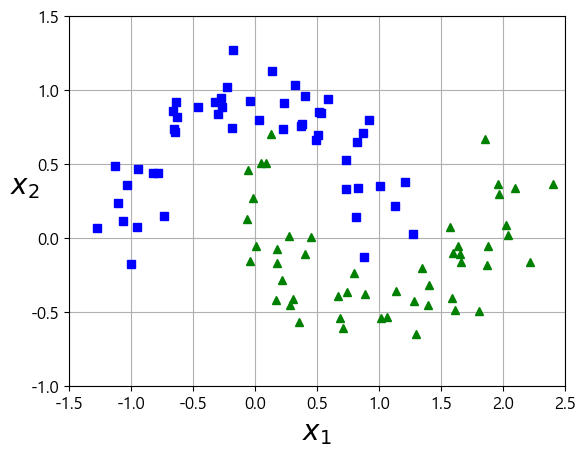

In [49]:
# 비선형을 설명하기 위한 데이터 생성
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

#print(X)
#print(y)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [50]:
# 비선형 SVM을 이용해서 위의 데이터를 훈련
from sklearn.preprocessing import PolynomialFeatures

# degree 값을 높이면 차수가 높아져서 곡선이 복잡해짐
# 훈련 데이터에 대해서는 잘 구분하게 됨
# 너무 높게 설정하면 훈련 데이터는 잘 구분하지만 새로운 데이터는 잘 구분하지 못할 수 있음
# 이러한 상황을 overfitting(과적합) 이라고 함
# 보통 degree값과 C값을 조절해가는 편
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)


C:\Users\USER\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))])

그림 저장: moons_polynomial_svc_plot


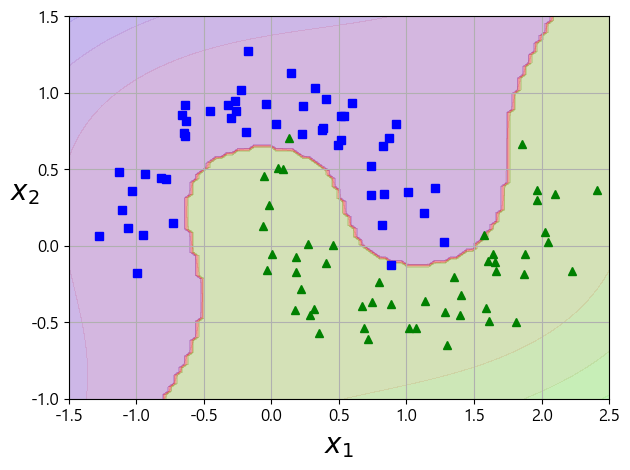

In [51]:
# 결정 경계와 데이터의 분포를 시각화

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

# 분류가 잘 안되거나 성능이 낮다고 생각이 들면
# degree 값을 올려보기

### 가우시안 RBF커널을 이용한 비선형 SVM

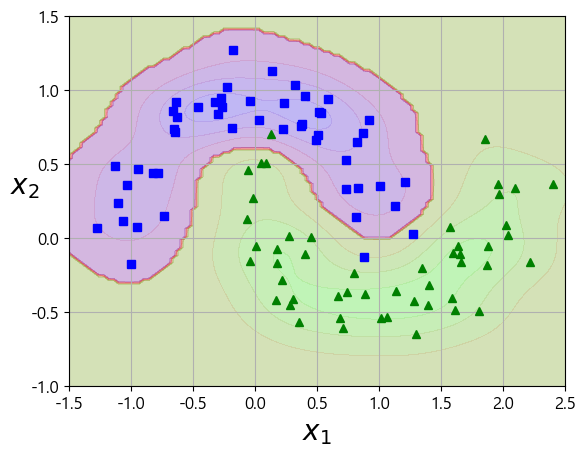

In [53]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

plot_predictions(rbf_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

# 하이퍼 파라미터 감마를 사용하는데 이 값을 증가시키면 종 모양 그래프가 좁아져서
# 각 샘플의 영향 범위가 작아져서 결정 경계가 조금 더 불규칙해지며 작은 감마 값은 넓은 종 모양 그래프를 만들어 냄



### Decision Tree(결정 나무)

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [58]:
pip install graphviz

     ---------------------------------------- 47.0/47.0 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!conda install pygraphviz

In [4]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(
        tree_clf,
        out_file="iris_tree.dot",
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

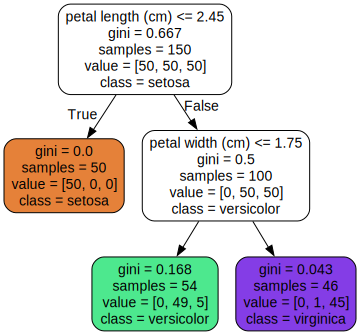

In [5]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'


with open('iris_tree.dot') as f:
    dot_graph = f.read()
src = graphviz.Source(dot_graph)

src

In [6]:
# 시각화 결과를 이미지로 저장
import pygraphviz as pga
from IPython.display import Image
graph = pga.AGraph('./iris_tree.dot')
graph.draw("iris_tree.png", prog='dot')
Image("iris_tree.png")

ModuleNotFoundError: No module named 'pygraphviz'

In [7]:
# 예측
y_pred = tree_clf.predict([[5,1.5]])
# 확률 예측
y_proba = tree_clf.predict_proba([[5,1.5]])
print(y_pred)
print(y_proba)

[1]
[[0.         0.90740741 0.09259259]]


In [8]:
print(tree_clf.feature_importances_)

[0.56199095 0.43800905]


### 타이타닉 데이터를 이용한 생존 여부 분류 - 결정 트리 모델 활용

In [12]:
# 데이터 가져오기
df = sns.load_dataset("titanic")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [13]:
# 결측치 처리
# deck열은 결측치가 너무 많아서 deck 열을 제거
# embark_town은 embarked와 내용이 중복이라서 제거 
rdf = df.drop(['deck','embark_town'], axis=1)
# age열은 결측치가 아주 많지 않기 때문에 결측치 데이터(행) 제거(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0) 
# embarked 열은 결측치가 2개라서 최빈값으로 대체
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
rdf['embarked'].fillna(most_freq, inplace=True)
 
rdf.head()



,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,no,True


In [14]:
# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  714 non-null    int64  
 1   pclass    714 non-null    int64  
 2   sex       714 non-null    object 
 3   age       714 non-null    float64
 4   sibsp     714 non-null    int64  
 5   parch     714 non-null    int64  
 6   embarked  714 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 44.6+ KB


In [32]:
# 범주형인지 확인 - 2개의 값만 존재
# 범주형일 때 확인 - 순서 여부를 확인
# 순서가 없을 때는 원핫 인코딩을 하고 순서가 있는 경우에는 Ordinal Encoding을 수행

ndf['sex'].unique()

KeyError: 'sex'

In [16]:
# 순서가 없으므로 원 핫 인코딩
onehot_sex = pd.get_dummies(ndf['sex'])
#print(onehot_sex)

# 기존 데이터프레임에 원 핫 인코딩 한 결과 추가
ndf = pd.concat([ndf, onehot_sex], axis=1)
print(ndf.head())

   survived  pclass     sex   age  sibsp  parch embarked  female  male
0         0       3    male  22.0      1      0        S       0     1
1         1       1  female  38.0      1      0        C       1     0
2         1       3  female  26.0      0      0        S       1     0
3         1       1  female  35.0      1      0        S       1     0
4         0       3    male  35.0      0      0        S       0     1


In [17]:
# 순서가 없으므로 원 핫 인코딩 -> 컬럼 이름 앞에 town을 붙여서 컬럼 이름을 생성
onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
#print(onehot_sex)

# 기존 데이터프레임에 원 핫 인코딩 한 결과 추가
ndf = pd.concat([ndf, onehot_embarked], axis=1)
print(ndf.head())

   survived  pclass     sex   age  sibsp  parch embarked  female  male  \
0         0       3    male  22.0      1      0        S       0     1   
1         1       1  female  38.0      1      0        C       1     0   
2         1       3  female  26.0      0      0        S       1     0   
3         1       1  female  35.0      1      0        S       1     0   
4         0       3    male  35.0      0      0        S       0     1   

   town_C  town_Q  town_S  
0       0       0       1  
1       1       0       0  
2       0       0       1  
3       0       0       1  
4       0       0       1  


In [18]:
# 원 핫 인코딩 한 컬럼 제거
ndf.drop(['sex', 'embarked'], axis=1, inplace=True)
print(ndf.head())

   survived  pclass   age  sibsp  parch  female  male  town_C  town_Q  town_S
0         0       3  22.0      1      0       0     1       0       0       1
1         1       1  38.0      1      0       1     0       1       0       0
2         1       3  26.0      0      0       1     0       0       0       1
3         1       1  35.0      1      0       1     0       0       0       1
4         0       3  35.0      0      0       0     1       0       0       1


In [19]:
# 피처와 타겟 생성
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S']]
y=ndf['survived']
print(X.head())
print(y.head())

   pclass   age  sibsp  parch  female  male  town_C  town_Q  town_S
0       3  22.0      1      0       0     1       0       0       1
1       1  38.0      1      0       1     0       1       0       0
2       3  26.0      0      0       1     0       0       0       1
3       1  35.0      1      0       1     0       0       0       1
4       3  35.0      0      0       0     1       0       0       1
0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64


In [23]:
# 피처(독립 변수, 설명 변수)를 정규화
# 피처들의 값의 범위나 분포가 차이가 많이 나는 경우 수행
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
print(X[0])

[ 0.911 -0.53   0.525 -0.506 -0.759  0.759 -0.472 -0.202  0.533]


In [24]:
# 훈련 데이터와 테스트 데이터를 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

print(X_train.shape)
print(X_test.shape)

(499, 9)
(215, 9)


In [37]:
# 모델을 선택해서 훈련
from sklearn import tree
# 불순도 지표는 엔트로피를 사용하고 중간 가지의 최대 개수는 5
tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)  

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

In [38]:
# 예측
y_hat = tree_model.predict(X_test)

In [39]:
# 예측된 결과 확인
print(y_hat[0:10])
print(y_test.values[0:10])

[0 0 1 0 0 1 1 0 0 0]
[0 0 1 0 0 1 1 1 0 0]


In [40]:
# 평가 지표 확인
from sklearn import metrics
# 오차 행렬 출력
tree_matrix = metrics.confusion_matrix(y_test, y_hat)
print(tree_matrix)
# 나머지 평가 지표
tree_report = metrics.classification_report(y_test, y_hat)
print(tree_report)

[[121   4]
 [ 35  55]]
              precision    recall  f1-score   support

           0       0.78      0.97      0.86       125
           1       0.93      0.61      0.74        90

    accuracy                           0.82       215
   macro avg       0.85      0.79      0.80       215
weighted avg       0.84      0.82      0.81       215



9


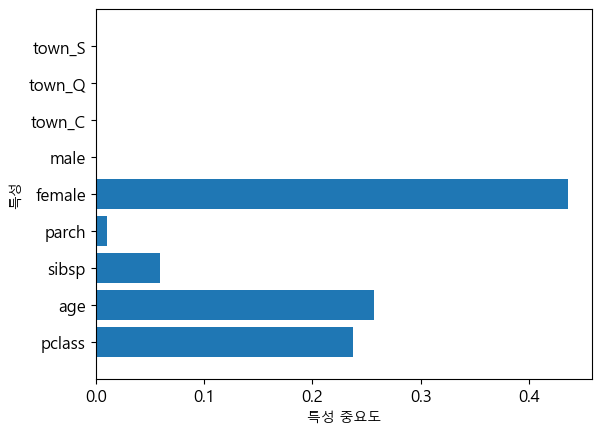

In [42]:
# 피처의 중요도 출력
n_features = X.data.shape[1]

plt.barh(np.arange(n_features), tree_model.feature_importances_, align='center')
plt.yticks(np.arange(n_features), ['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S'])
plt.xlabel("특성 중요도")
plt.ylabel("특성")
plt.ylim(-1, n_features)
plt.show()

In [48]:
from sklearn.model_selection import GridSearchCV
# 하이퍼 파라미터 조정
# 위에서 모델 만들 때 max_depth=5로 지정해뒀는데 이 수치를 조정해가면서
# 좋은 값을 찾기
# min_samples_split : 노드를 분할하기 위한 최소한의 샘플 데이터수
# 
params = {
    'max_depth' : [2 ,4, 6, 8 ,10, 12, 16 ,20, 24],
    'min_samples_split':[4,8,16,24,32]
}

grid_cv = GridSearchCV(tree_model, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(X_train , y_train)
print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
GridSearchCV 최고 평균 정확도 수치:0.8157
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 4, 'min_samples_split': 8}
